# 05 - 1 검증 세트를 나누고 전처리 과정을 배운다.

###테스트 세트로 모델을 튜닝한다.

**로지스틱 회귀로 모델 훈련하고 평가하기**

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y,
                                                            test_size = 0.2, random_state=42)

다음으로 SGDClassifier 클래스를 이용하여 로지스틱 회귀 모델을 훈련하고 평가해보자.

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.8333333333333334

테스트 세트에서 정확도는 약 83%이다.
여기서 loss처럼 사용자가 직접 선택해야하는 파라미터를 하이퍼파리미터(hyperparameter)라고 부른다. loss의 값을 바꾸면 성능이 좋아지는지 확인해보자.

**서포트 벡터 머신으로 모델 훈련하고 평가하기**

SGDClassifier 클래스의 loss 매개변수를 log에서 hinge로 바꾸면 선형 서포트 벡터 머신(Support Vector Machine; SVM) 문제를 푸는 모델이 만들어진다. 여기서 SVM이란 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업' 정도로 이해하면 된다.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss ='hinge', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

이런식으로 매개변수를 바꿔보는 작업들을 '모델을 튜닝한다'고 한다.


성능이 이전보다 높게 나왔지만, 이 모델은 실전에서 좋은 성능을 내지 못할 확률이 높다.

### 테스트 세트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 어렵다.

테스트 모델로 튜닝을 하게되면 테스트 세트의 정보가 모델에 새어나가므로 모델의 일반화 성능 (generalization performance)이 왜곡 된다.

###검증 세트를 준비한다.

그러면 어떻게 해야할까?
모델을 튜닝할때 테스트 세트를 사용하지 않으면된다. 따로 모델을 튜닝하는 용도의 세트인 검증세트를 만든다. 이는 훈련 세트를 조금 떼어서 만든다.

**1. 데이터 세트 준비하기**

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

2. 검증 세트 분할하기

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size=0.2, random_state = 42)
print(len(x_train), len(x_val))

364 91


3. 검증 세트 사용해 모델 평가하기

In [ ]:
sgd = SGDClassifier(loss='log', random_state = 42)
sgd.fit(x_train, y_train)
sgd.score(x_val,y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.6923076923076923

사실 이 데이터셋의 샘플 개수는 적은 편이다. 데이터 양이 작으니 검증 세트의 비율이나 random_state 매개변수의 값을 조금만 조절해도 성능 평가 점수가 크게 변한다.

###데이터 전처리와 특성의 스케일을 알아보자.

사이킷런과 같은 머신러닝 패키지에 준비되어 있는 데이터는 대부분 실습을 위한 것이므로 잘 가공되어있다. 하지만 실전에서 수집된 데이터는 그렇지 않다. 이런 데이터들을 사용하면 제대로 된 결과를 얻을 수 없다. 이런 경우 데이터를 적절히 가공하는 '데이터 전처리(data preprocessing)'과정
이 필요하다.


**특성의 스케일은 알고리즘에 영향을 준다.**

스케일이란 어떤 특성이 가지고 있는 값의 범위를 말한다.
스케일을 조정하면 어떠한 이점이 있을까?

### 스케일을 조정하지 않고 모델을 훈련해보자.

1. 훈련 데이터 준비하고 스케일 비교하기

두 가지 특성을 박스 플롯을 그려서 스케일을 확인해보자.

['mean perimeter' 'mean area']


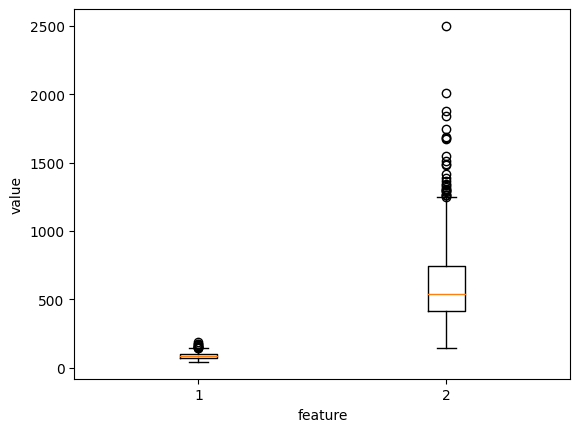

In [ ]:
import matplotlib.pyplot as plt

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

그래프로 보니 두 특성의 스케일은 차이가 크다. 이렇게 스케일이 다른 두 특성에 경사 하강법 알고리즘을 적용하면 가중치가 어떻게 변할까?

2. 가중치를 기록할 변수와 학습률 파라미터 추가하기

SingleLayer 클래스에 인스턴스 변술르 추가하여 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰할 때 사용하자. 또 학습률이라는 개념도 도입하자. 먼저 init()메서드에서 인스턴스 변수 w_history를 만들고 학습률 파라미터 learning_rate를 추가하자

In [ ]:
class SingleLayer():
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []   #손실함수의 결과값을 저장할 리스트. 샘플마다 손실 함수를 계산하고 그 결괏값을 모두 더해 샘플 개수로 나눈 평균값을 저장
    self.w_history = []
    self.lr = learning_rate

    #2.정방향 계산
  def forpass(self,x):
      z = np.sum(x*self.w)+self.b
      return z

    #3.역방향 계산
  def backprop(self,x,err):
      w_grad = x*err
      b_grad = 1*err
      return w_grad, b_grad

  def add_bias(self,x):
      return np.c_[np.ones((x.shpae[0],1)),x]   #행렬의 맨 앞에 1로 채워진 열 벡터를 추가

    #5.activation()메서드 구현;시그모이드 계산
  def activation(self,z):
      a = 1/(1+np.exp(-z))
      return a

    #6.훈련을 위한 fit()메서드 구현
  def fit(self, x, y, epochs=100):
      self.w = np.ones(x.shape[1])
      self.b = 0
      self.w_history.append(self.w.copy())
      np.random.seed(42)
      for i in range(epochs):
        loss =0
        indexes = np.random.permutation(np.arange(len(x)))  #인덱스 섞기
        for i in indexes:
          z = self.forpass(x[i])
          a = self.activation(z)
          err = -(y[i]-a)
          w_grad, b_grad = self.backprop(x[i],err)
          self.w -= w_grad
          self.b -= b_grad
          #가중치를 기록
          self.w_history.append(self.w.copy())
          #안전한 로그 계산을 위해 클리핑한 후 손실을 누적
          a = np.clip(a, 1e-10, 1-1e-10)    #np.clip() : 주어진 범위 밖의 값을 범위 양 끝의 값으로 잘라냄.
          loss +=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
        self.losses.append(loss/len(y))   #에포크마다 평균 손실 저장

    #7.에측하는 메서드 구현
  def predict(self,x):
      z = [self.forpass(x_i) for x_i in x]
      return np.array(z) > 0

    #8.정확도 계산을 위한 score()메서드 구현

  def score(self,x,y):
      return np.mean(self.predict(x)==y)


learning_rate는 하이퍼파라미터이며 변수 이름 그대로 '학습률'을 의미하는데 이 값으로 가중치의 업데이트 양을 조절한다.

3. 가중치 기록하고 업데이트 양 조절하기

이제 fit() 메서드에서 가중치가 바뀔 때마다 w_history 리스트에 가중치를 가록하자.

4. 모델 훈련하고 평가하기

In [ ]:
import numpy as np

layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

<ipython-input-8-dd84dfd27a10>:25: RuntimeWarning: overflow encountered in exp
  a = 1/(1+np.exp(-z))


0.9120879120879121

5. layer1 객체에 인스턴스 변수 w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록되어 있다. 이때 세 번째, 네 번째 요소(w[2], w[3])는 각각 mean perimeter와 mean area 특성에 대한 가중치이다. 이 요소로 그래프를 그려보자 또 최종으로 결정된 가중치는 점으로 표시해보자.

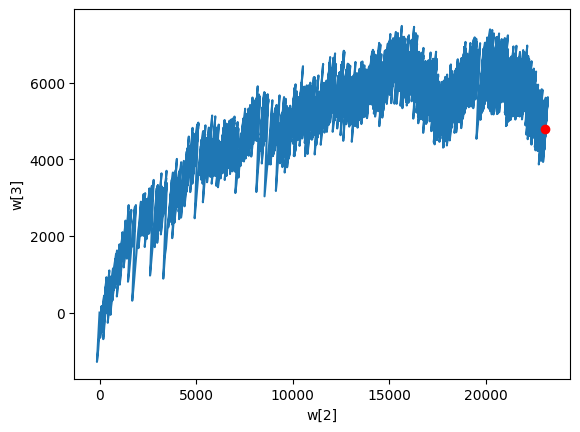

In [ ]:
w2 = []
w3 = []

for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

그래프를 보면 mean perimeter에 비해 mean area의 스케일이 크므로 w3 값이 학습 과정에서 큰 폭으로 흔들리며 변화하고 있다.

이런 현상을 줄이기 위해 스케일을 조정한다.

스케일을 조정해 모델을 훈련한다.

스케일을 조정하는 방법은 많지만 신경망에서 자주 사용하는 스케일 조정 방법 중 하나는 표준화(standardization)이다. 표준화는 특성값에서 평균을 빼고 표준 편차로 나누면 된다.

1. 넘파이로 표준화 구현하기.

In [ ]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

2. 모델 훈련하기

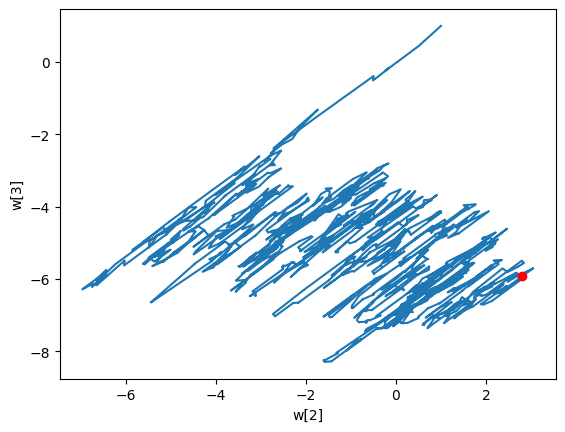

In [ ]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

3. 모델 성능 평가하기

검증 세트에서 모델의 성능을 평가해보자.

In [ ]:
layer2.score(x_val, y_val)

0.37362637362637363

4. 성능이 매우 좋지 않다. 이는 검증 세트의 스케일을 바꾸지 않았기 때문에 일어난 일이다.

In [ ]:
val_mean = np.mean(x_val, axis = 0)
val_std = np.std(x_val, axis = 0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.9560439560439561

검증 세트에 대한 정확도가 약 96%이다. 여기엔 조심해야 할 교묘한 함정이 숨어있다.

###스케일을 조정한 다음에 실수하기 쉬운 함정을 알아보자.

1. 원본 훈련 세트와 검증 세트로 산점도를 그리자.

(파란 점이 훈련 세트, 빨간 점이 검증세트)

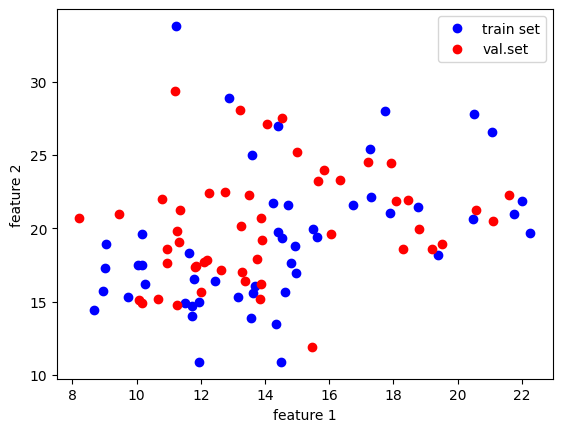

In [ ]:
plt.plot(x_train[:50,0], x_train[:50,1], 'bo')
plt.plot(x_val[:50,0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val.set'])
plt.show()

2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기

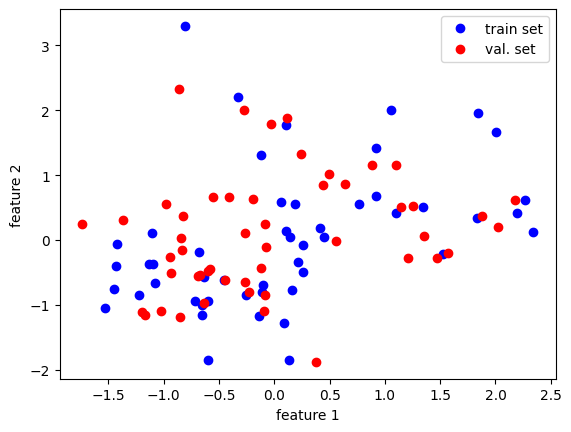

In [ ]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

산점도를 자세히 비교해보면 조금 미세하지만 서로 다른 비율로 변환되었음을 알 수 있다.

이는 훈련 세트와 검증 세트를 각각 다른 비율로 전처리했기 때문이다.

3. 올바르게 검증 세트 전처리하기

훈련 세트의 평균, 표준 편차를 사용하여 검증 세트를 변환한다.

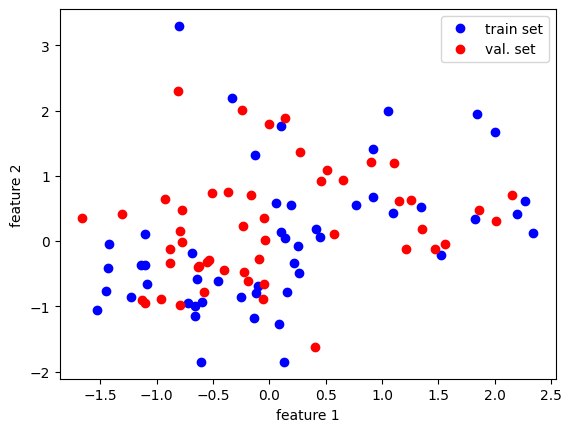

In [ ]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

이제 원본 데이터의 산점도와 스케일 조정 이후 산점도가 같아졌다.

4. 모델 평가하기

In [ ]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

#05 -2 과대적합과 과소적합을 알아보자.

###과대적합과 과소적합을 알아보자.

과대적합이란 모델이 훈련세트에서는 좋은 성능을 내지만 검정 세트에서는 낮은 성능을 내는 경우를 말한다.

과소적합은 훈련 세트와 검증 세트의 성능에는 차이가 크지 않지만 모두 낮은 성능을 내는 경우이다.


<br>

과대적합은 훈련 세트와 검증 세트에서 측정한 성능의 간격이 크다. 그래서 과대적합된 모델을 '분산이 크다 (high variance)'라고도 말한다. 과대적합의 주요원인 중 하나는 훈련 세트에 충분히 다양한 패턴의 샘플이 포함되지 않은 경우이다. 이런 경우에는 더 많은 훈련 샘플을 모아 검증 세트의 성능을 향상시킬 수 있다. 만약 훈련 샘플을 더 많이 모을 수 없는 경우 무델이 훈련 세트에 집착하지 않도록 가중치를 제한할 수 있다. 이를 '모델의 복잡도를 낮춘다' 라고도 말한다.

과소적합은 훈련세트와 검증 세트에서 측정한 성능의 간격은 점점 가까워지지만 성능 자체가 낮다. 그래서 과소적합된 모델을 '편향이 크다(high bias)'라고도 말한다. 과소적합은 모델이 충분히 복잡하지 않아 훈련 데이터에 있는 패턴을 모두 잡아내지 못하는 현상이다. 과소적합을 해결하는 대표적인 방법은 더 높은 모델을 사용하거나 가중치의 규제를 완화하는 것이다.

<br>

**에포크와 손실함수로 과대적합과 과소적합 분석하기**

<br>

훈련 세트의 손실은 에포크가 진행될수록 감소하고, 검증 세트의 손실은 에포크 횟수가 최적점을 지나면 오히려 상승한다. 즉 과대적합되기 시작한다.(최적점 이후에도 계속해서 훈련세트로 모델을 훈련시키면 모델이 훈련 세트의 샘플에 더 밀착하여 학습하기 때문이다.)

최적점 이전에는 훈련 세트와 검증 세트의 손실이 비슷한 간격을 유지하면서 함께 줄어든다. 이 영역에서 학습을 중지시키면 과소적합된 모델이 만들어진다.

<br>

**모델 복잡도와 손실 함수의 그래프로 과대적합과 과소적합 분석하기**

<br>

모델복잡도란 모델이 가진 학습 가능한 가중치 개수를 말하는데, 층의 개수나 유닛의 개수가 많아지면 복잡도가 높은 모델이 만들어진다.


###적절한 편향-분산 트레이드오프를 선택한다.

과소적합된 모델은 '편향되었다'라고 하고 과대적합된 모델은 '분산이 크다'라고 한다고 했다. 과소적합된 모델(편향)과 과대적합된 모델(분산)사이의 관계를 편향 - 분산 트레이드오프(bias-variance tradeoff)라고 한다.

편향과 분산은 서로 반비례관계이다. 우리는 여기서 적절한 편향 - 분산 트레이드 오프를 선택해야한다.  분산이나 편향이 너무 커지지 않도록 적절한 중간지점을 선택하는 것이다.

In [ ]:
# 1. 검증 손실을 기록하기 위한 변수 추가 (self.val_losses)

class SingleLayer():
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []   #손실함수의 결과값을 저장할 리스트. 샘플마다 손실 함수를 계산하고 그 결괏값을 모두 더해 샘플 개수로 나눈 평균값을 저장
    self.val_losses = [] #인스턴스 변수 추가
    self.w_history = []
    self.lr = learning_rate

    #2.정방향 계산
  def forpass(self,x):
      z = np.sum(x*self.w)+self.b
      return z

    #3.역방향 계산
  def backprop(self,x,err):
      w_grad = x*err
      b_grad = 1*err
      return w_grad, b_grad

  def add_bias(self,x):
      return np.c_[np.ones((x.shpae[0],1)),x]   #행렬의 맨 앞에 1로 채워진 열 벡터를 추가

    #5.activation()메서드 구현;시그모이드 계산
  def activation(self,z):
      a = 1/(1+np.exp(-z))
      return a

    #6.훈련을 위한 fit()메서드 구현 + 검증세트 전달 받을 수 있도록 매개변수 추가
  def fit(self, x, y, epochs=300, x_val = None, y_val = None):
      self.w = np.ones(x.shape[1])
      self.b = 0
      self.w_history.append(self.w.copy())
      np.random.seed(42)
      for i in range(epochs):
        loss =0
        indexes = np.random.permutation(np.arange(len(x)))  #인덱스 섞기
        for i in indexes:
          z = self.forpass(x[i])
          a = self.activation(z)
          err = -(y[i]-a)
          w_grad, b_grad = self.backprop(x[i],err)
          self.w -= w_grad
          self.b -= b_grad
          #가중치를 기록
          self.w_history.append(self.w.copy())
          #안전한 로그 계산을 위해 클리핑한 후 손실을 누적
          a = np.clip(a, 1e-10, 1-1e-10)    #np.clip() : 주어진 범위 밖의 값을 범위 양 끝의 값으로 잘라냄.
          loss +=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
        self.losses.append(loss/len(y))   #에포크마다 평균 손실 저장
        self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실을 계산

    #7.에측하는 메서드 구현
  def predict(self,x):
      z = [self.forpass(x_i) for x_i in x]
      return np.array(z) > 0

    #8.정확도 계산을 위한 score()메서드 구현

  def score(self,x,y):
      return np.mean(self.predict(x)==y)

    #9.검증 손실 계산하기
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])       #정방향 계산
      a = self.activation(z)           #활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val))

이 계산은 fit() 메서드에서 훈련 세트의 손실을 계산하는 방식과 동일하다.

4. 모델 훈련하기.

In [ ]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

5. 손실값으로 그래프 그려 에포크 횟수 지정하기.

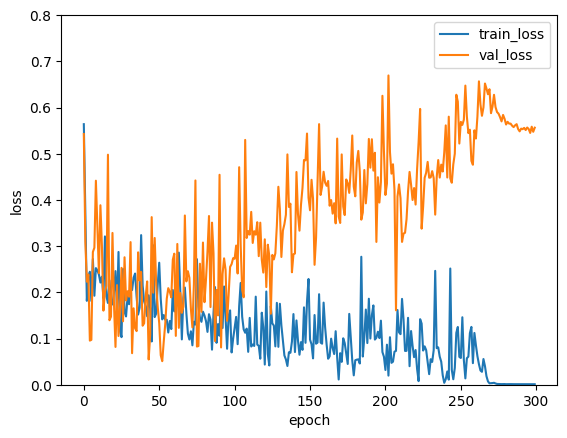

0.9560439560439561

In [ ]:
plt.ylim(0, 0.8)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()
layer3.score(x_val_scaled, y_val)

에포크를 300까지 했을 경우 약 100번째 에포크 부터 검증 손실이 훈련 세트보다 높아지는 것을 알 수있다.

6. 훈련 조기 종료하기

이렇게 훈련을 일찍 멈추는 기법을 조기 종료(early stopping)이라고 부른다. 100번의 에포크까지 모델을 훈련한 다음 검정 세트의 성능을 확인해보자,

In [ ]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.967032967032967

#05-3 규제 방법을 배우고 단일층 신경망에 적용한다.

가중치 규제란 말 그대로 가중치의 값이 커지지 않도록 제한하는 기법이다. 가중치를 규제하면 모델의 일반화 성능이 올라간다.

### L1 규제

L1 규제는 손실 함수에 가중치의 절댓값인 L1 노름(norm) - (전체 가중치 각각 절댓값의 합을 더한 것)을 추가한다.

L1 노름은 다음과 같다.

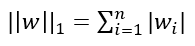



소문자 알파벳(w)은 벡터를 의미한다. (n : 가중치의 계수)

L1 노름에 규제의 양을 조절하는 하이퍼파라미터 a를 곱해 손실함수에 더한다.

 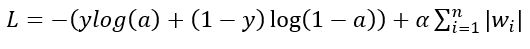

규제가 약해진다 = a의 값이 작으면 w의 합이 커져도 손실함수의 값이 큰 폭으로 커지지 않음

규제가 강해진다 = a값이 크면 전체 손실 함수의 값이 커지지 않도록 w값의 합이 작아져야함

###L1 규제의 미분

여기서는 L1규제만 미분해보자.

절댓값 w를 w에대해 미분하면 값의 부호만 남기때문에 w의 부호라는 의미로 sign(w)이라고 표현한다. L1 규제를 적용한 손실함수의 도함수는 다음과 같다.

$\frac{∂}{∂w}L = -(y-a)x + a * sign(w)$

여기에서는 가중치 벡터 w에 대한 미분으로 확장하여 식을 전개했다. 이 식을 가중치 업데이트 식에 적용하면 다음과 같다.


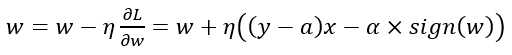

L1 규제를 추가한 로지스틱 손실 함수를 경사 하강법으로 최적화하는 것도 어렵지 않을 것 같다. 규제 하이퍼파라미터 a와 가중치의 부호를 곱해서 업데이트할 그레이디언트에 더해주면 된다.

파이썬 코드로 작성하면 다음과 같다.


```
w_grad += alpha * np.sign(w)
```

여기서 alpha 변수가 규제 하이퍼파라미터이다. np.sigh() 함수는 배열 요소의 부호를 반환한다.

우리는 여기서 절편에 대해 규제를 하지 않는다. 절편을 모델을 어떤 방향으로 이동시킬 뿐 복잡도에는 영향을 주지 않는다.

**회귀 모델에 L1 규제를 추가한 것을 라쏘 모델이라 한다.**

라쏘는 가중치를 줄이다 못해 일부 가중치를 0으로 만들 수도 있다. 가중치가 0인 특성은 모델에서 사용할 수 없다는 것과 같은 의미이므로 특성을 선택하는 효과를 얻을 수 있다. L1 규제는 규제 하이퍼파라미터 a에 많이 의존한다. 즉, 가중치의 크기에 따라 규제의 양이 변하지 않으므로 규제 효과가 좋다고 할 수 없다.

###L2 규제를 알아보자

L2 규제는 손실 함수에 가중치에 대한 L2 노름(norm)의 제곱을 더한다. L2노름은 다음과 같이 정의된다.

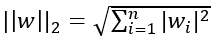

손실 함수에 L2 노름의 제곱을 더하면 L2 규제가 된다. 이때 a는 L1규제와 마찬가지로 규제의 양을 조절하기 위한 하이퍼파라미터이고 1/2은 미분 결과를 보기 좋게 하기 위하여 추가했다.

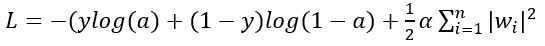

###L2 규제의 미분

로지스틱 손실 함수의 미분은 이전과 동일하게 진행하고, L2규제를 미분하면 간단히 w만 남는다.

L1 규제에서 sign(w)만 w로 바뀜.

L2 규제를 경사 하강법 알고리즘에 적용하는 것도 아주 쉽다.

```
w_grad += alpha * w
```

L2규제는 그레이디언트 계산에 가중치의 값 자체가 포함되므로 가중치의 부호만 사용하는 L1 규제보다 조금 더 효과적이다. 또 L2 규제는 가중치를 완전히 0으로 만들지 않는다. 가중치를 완전히 0으로 만들면 특성을 제외하는 효과는 있지만 모델의 복잡도가 떨어진다. 이런 이유로 L2 규제를 널리 사용한다.


**회귀 모델에 L2 규제를 적용한 것을 릿지 모델이라 한다.**

### 로지스틱 회귀에 규제를 적용한다.

1. 그레이디언트 업데이트 수식에 페널티 항 반영하기. 먼저 __init__() 메서드에 L1 규제와 L2 규제의 강도를 조절하는 매개변수 l1과 l2를 추가한다.


2.  fit() 메서드에서 역방향 계산을 수행할 때 그레이디언트에 페널티 항의 미분값을 더한다.

3. 로지스틱 손실 함수 계산에 페널티 항 추가하기

4. 마지막으로 검증 세트의 손실을 계산하는 update_val_loss() 메서드에서 reg_loss()를 호출하도록 수정

5. cancer 데이터 세트에 L1 규제 적용하기. 강도는 0.0001, 0.001, 0.01 세 가지로 하자.


In [ ]:
# 1. 검증 손실을 기록하기 위한 변수 추가 (self.val_losses)

class SingleLayer():
  def __init__(self, learning_rate=0.1, l1 = 0, l2 = 0):
    self.w = None
    self.b = None
    self.losses = []   #손실함수의 결과값을 저장할 리스트. 샘플마다 손실 함수를 계산하고 그 결괏값을 모두 더해 샘플 개수로 나눈 평균값을 저장
    self.val_losses = [] #인스턴스 변수 추가
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

    #2.정방향 계산
  def forpass(self,x):
      z = np.sum(x*self.w)+self.b
      return z

    #3.역방향 계산
  def backprop(self,x,err):
      w_grad = x*err
      b_grad = 1*err
      return w_grad, b_grad

  def add_bias(self,x):
      return np.c_[np.ones((x.shpae[0],1)),x]   #행렬의 맨 앞에 1로 채워진 열 벡터를 추가

    #5.activation()메서드 구현;시그모이드 계산
  def activation(self,z):
      a = 1/(1+np.exp(-z))
      return a

    #6.훈련을 위한 fit()메서드 구현 + 검증세트 전달 받을 수 있도록 매개변수 추가
  def fit(self, x, y, epochs=300, x_val = None, y_val = None):
      self.w = np.ones(x.shape[1])
      self.b = 0
      self.w_history.append(self.w.copy())
      np.random.seed(42)
      for i in range(epochs):
        loss =0
        indexes = np.random.permutation(np.arange(len(x)))  #인덱스 섞기
        for i in indexes:
          z = self.forpass(x[i])
          a = self.activation(z)
          err = -(y[i]-a)
          w_grad, b_grad = self.backprop(x[i],err)
          #그레이디언트에서 페널티 항의 미분값을 더한다
          w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
          self.w -= self.lr * w_grad
          self.b -= b_grad
          #가중치를 기록
          self.w_history.append(self.w.copy())
          #안전한 로그 계산을 위해 클리핑한 후 손실을 누적
          a = np.clip(a, 1e-10, 1-1e-10)    #np.clip() : 주어진 범위 밖의 값을 범위 양 끝의 값으로 잘라냄.
          loss +=-(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
        self.losses.append(loss/len(y) + self.reg_loss())   #에포크마다 평균 손실 저장
        self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실을 계산

    #7.에측하는 메서드 구현
  def predict(self,x):
      z = [self.forpass(x_i) for x_i in x]
      return np.array(z) > 0

    #8.정확도 계산을 위한 score()메서드 구현

  def score(self,x,y):
      return np.mean(self.predict(x)==y)

    #9.검증 손실 계산하기
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])       #정방향 계산
      a = self.activation(z)           #활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

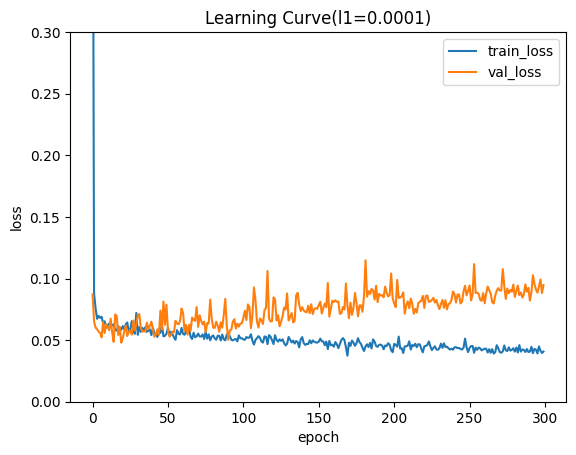

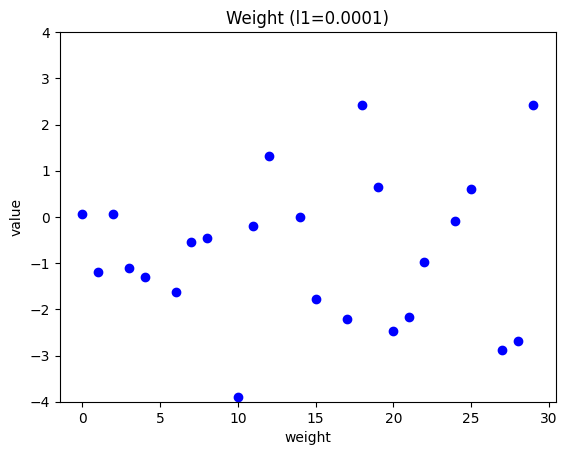

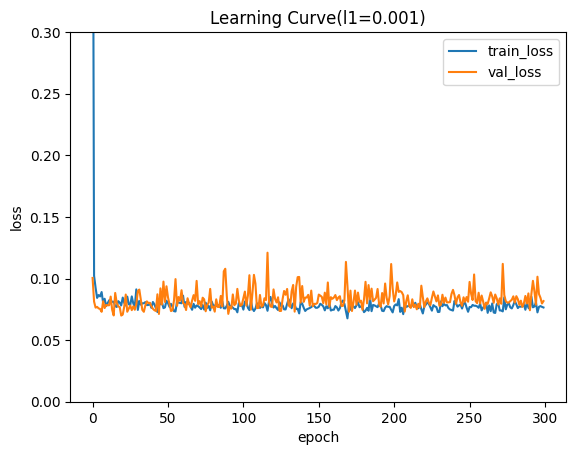

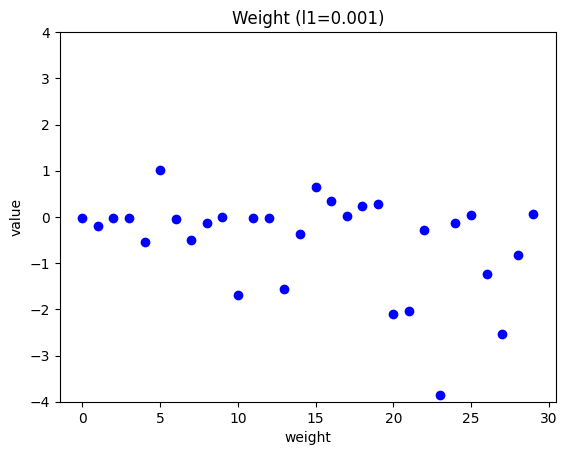

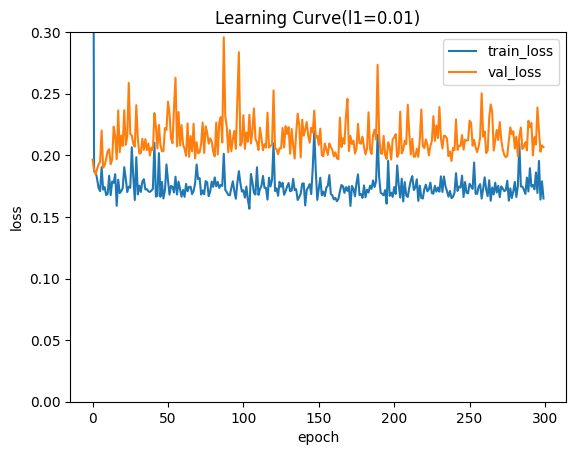

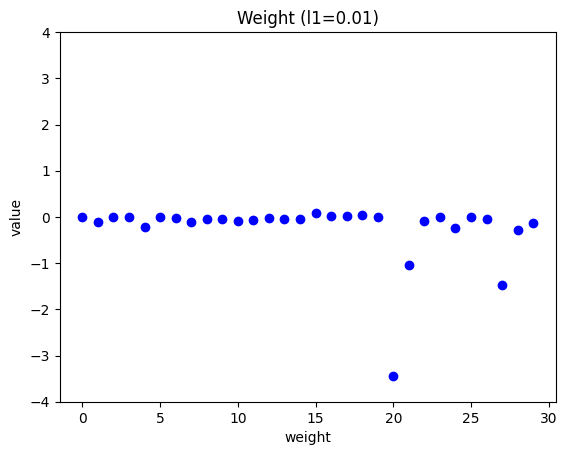

In [ ]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

 학습 곡선 그래프를 보면 규제가 더 커질수록 훈련 세트의 손실과 검증 세트의 손실이 모두 높아진다. 즉, 과소적합 현상이 나타난다. 그래프를 보면 적절한 l1 하이퍼파라미터 값은 0.001 정도인 것 같다. 이 값을 사용하여 모델의 성능을 확인해보자.

In [ ]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

6. cancecr 데이터 세트에 L2 규제 적용하기

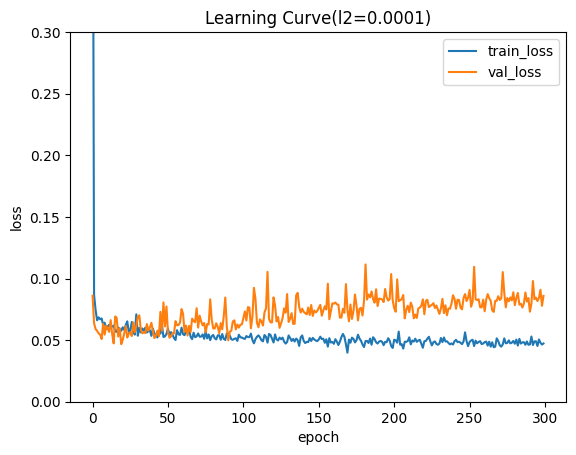

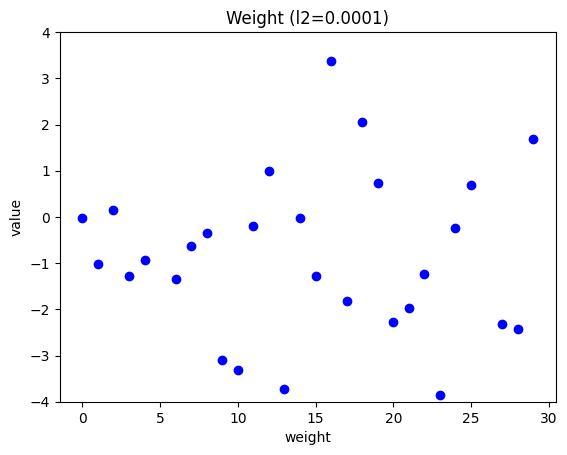

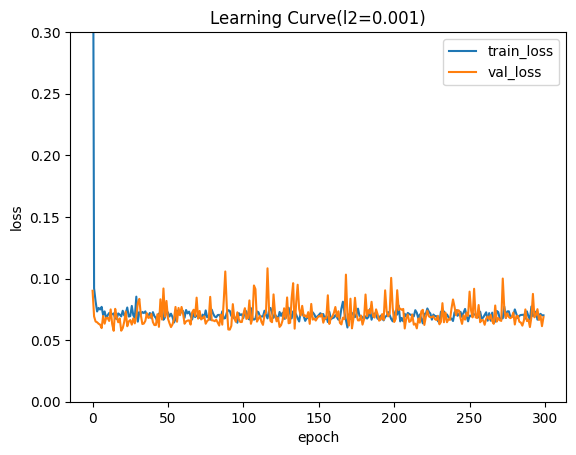

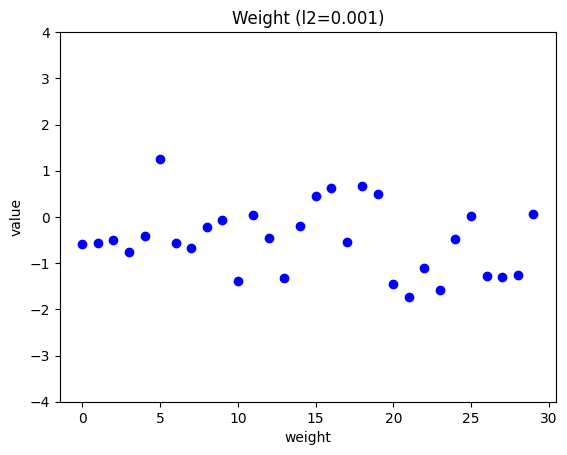

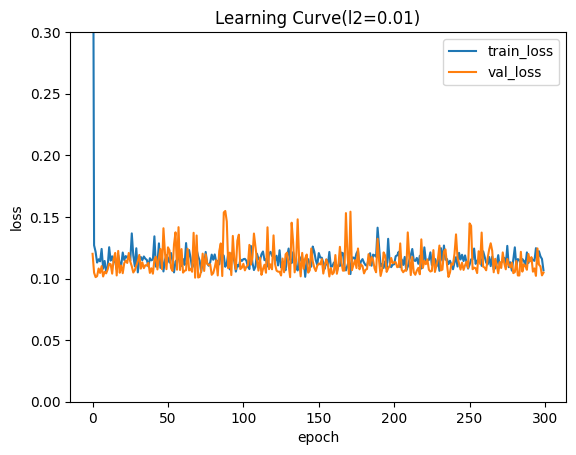

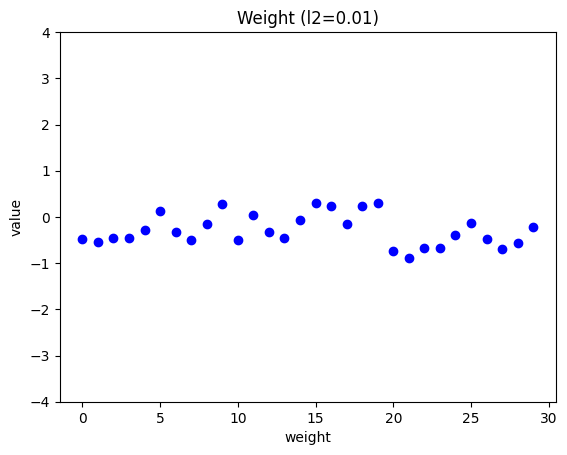

In [ ]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

L2 규제도 L1 규제와 비슷한 양상을 보인다. 하지만 마지막 학습 곡선 그래프를 보면 L2 규제는 규제 강도가 강해져도 L1 규제만큼 과소적합이 심해지지 않는다.

L2 규제를 적용한 모델 역시 50번의 에포크 횟수만큼 훈련하고 성능을 평가해보자.

In [ ]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

결과를 보니 L1 규제와 동일하다. 사실 cancer 데이터 샘플 개수는 아주 적어서 L1 규재를 적용한 모델과 L2 규제를 적용한 모델의 성능에는 큰 차이가 없다.

In [ ]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

7. SGDClassifier에서 규제 사용하기

In [ ]:
sgd = SGDClassifier(loss = 'log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.978021978021978

결과는 동일하다.

#05-4 교차 검증을 알아보고 사이킷런으로 수행해보자



### 교차 검증의 원리를 알아보자.

교차 검증은 훈련 세트를 작은 덩어리로 나누어 다음과 같이 진행하는데, 이때 훈련 세트를 나눈 작은 덩어리를 '폴드'라고 부른다. 이때 교차 검정은 훈련 세트를 k개의 폴드로 나누는 특징이 있으므로 k-폴드 교차 검증이라고 부른다.

### k-폴드 교차 검증을 구현하자.

1. 훈련 세트 사용하기

기존 방식은 전체 데이터 세트를 8:2로 나누어 훈련 세트와 테스트 세트를 얻음. 그런 다음 다시 훈련 세트를 8:2로 나누어 훈련 세트와 검증 세트를 얻었음.

즉, 훈련 , 검증, 테스트 세트를 완전히 나누었다. 하지만 k-폴드 교차 검증은 검증 세트가 훈련 세트에 포함된다.

또 각 폴드의 검증 점수를 저장하기 위한 validation_scores 리스트를 정의하자.

In [ ]:
validation_scores = []

2. k-폴드 교차 검증 구현하기.

In [ ]:
k = 10
bins = len(x_train_all) // k

for i in range(k):
  start = i*bins
  end = (i+1)*bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]

  train_index = list(range(0, start)) + list(range(end, len(x_train_all)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold, axis=0)
  train_std = np.std(train_fold, axis=0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std

  lyr = SingleLayer(l2 = 0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))



0.9711111111111113


이 코드에서 특히 신경 써서 봐야 할 부분은 훈련 데이터의 표준화 전처리를 폴드를 나눈 후에 수행한다는 점이다. 만약 폴드를 나누기 전에 전체 훈련 데이터를 전처리한다면 검증 폴드의 정보를 누설하게 되는 셈이다.

###사이킷런으로 교차 검증을 한다.

사이킷런의 model_selection 모듈에는 교차 검증을 위한 cross_validate() 함수가 있다.

1. cross_validate() 함수로 교차 검증 점수 계산하기.

In [ ]:
from sklearn.model_selection import cross_validate

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

cross_validate() 함수는 파이썬 딕셔너리를 반환한다. 교차 검증의 평균 점수는 약 85%로 낮은 편이다. 이유는 표준화 전처리를 수행하지 않았기 때문이다.

### 전처리 단계 포함해 교차 검증을 수행

훈련 세트를 표준화 전처리하기 전에 생각해 볼 것이 있다. 앞에서는 교차 검증을 구현할 때 폴드를 나눈 후에 훈련 폴드의 통계치로 검증 폴드를 전처리했다. 검증 폴드가 전처리 단계에서 누설되면 안되기 때문이다. 만약 훈련 세트 전체를 전처리한 후에 cross_validate() 함수에 매개변수 값으로 전달하면 검증 폴드가 표준화 전처리 단계에서 누설된다. 그래서 새로운 방법을 찾아야한다.

**Pipeline 클래스 사용해 교차 검증 수행하기**

사이킷런은 검증 폴드가 전처리 단계에서 누설되지 않도록 전처리 단계와 모델 클래스를 하나로 연결해 주는 Pipeline 클래스를 제공한다.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

평균 검증 점수가 높아졌다.

추가로 cross_validate() 함수에 return_train_score 매개변수를 True로 설정하면 훈련 폴드의 점수도 얻을 수 있다.

In [ ]:
print(np.mean(scores['train_score']))

0.9875478561631581
